In [1]:
import pandas as pd
from plotnine import *
from geopandas import GeoDataFrame

%matplotlib inline

In [2]:
shp_path = 'gis_osm_roads_free_1.shp'
roads = GeoDataFrame.from_file(shp_path, encoding='utf-8')
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4412349,5112,trunk,None,М-10,F,90,0,F,F,"LINESTRING (34.8230332 57.3829918, 34.8263046 ..."
1,4412351,5112,trunk,None,М-10,F,90,0,F,F,"LINESTRING (34.7432594 57.4401731, 34.7453505 ..."
2,4412353,5112,trunk,«Россия»,М-10,F,90,0,F,F,"LINESTRING (34.6612746 57.4975359, 34.6667788 ..."
3,4412397,5141,service,None,None,B,0,0,F,F,"LINESTRING (33.850453 57.8081654, 33.8506119 5..."
4,4418736,5132,trunk_link,None,None,F,0,0,F,F,"LINESTRING (32.1191751 54.7048519, 32.1216124 ..."


Define bounding box

In [3]:
center = [55.75, 37.61]
top = 55.95
bottom = 55.55
left = 37.35
right = 37.85

In [4]:
from shapely.geometry import box
from shapely.geometry import Polygon

bbox = box(left, bottom, right, top)

crs = {'init': 'epsg:4326'}
polygon = GeoDataFrame(index=[0], crs=crs, geometry=[bbox])

Drop roads that don't have name

In [5]:
selected = roads.dropna(subset=['name'])
selected.shape

(193813, 11)

Select only roads in bounding box

In [6]:
moscow = selected.loc[selected['geometry'].apply(lambda g: bbox.contains(g))].copy()
moscow.shape

(23182, 11)

Now to define street designations. In Russian, street designations can precede the name (*улица* Пестеля) or follow the name (Малая Грузинская *улица*) or even come in the middle if the street has a number (1-я *улица* Энтузиастов). Let's identify the prefixes and postfixes to find possible street designations.

In [7]:
moscow['prefix'] = moscow['name'].apply(lambda name: name.split(' ')[0])
moscow['postfix'] = moscow['name'].apply(lambda name: name.split(' ')[-1])

Find designations in street names. I've singled out "вал" (rampart) since many streets carry this designation to remind of old fortification lines.

| Russian | English |
| --- | --- |
| переулок | lane |
| улица | street |
| вал | rampart |
| проезд | drive |
| проспект | avenue |
| шоссе | highway |
| площадь | square |
| набережная | embankment |
| бульвар | boulevard |
| тупик | close |
| магистраль | motorway |

In [8]:
def get_designation(name):
    name = name.lower()
    if 'переулок' in name: return 'переулок'
    elif ' вал' in name: return 'вал'
    elif 'улица' in name: return 'улица'
    elif 'проезд' in name: return 'проезд'
    elif 'проспект' in name: return 'проспект'
    elif 'шоссе' in name: return 'шоссе'
    elif 'площадь' in name: return 'площадь'
    elif 'набережная' in name: return 'набережная'
    elif 'бульвар' in name: return 'бульвар'
    elif 'тупик' in name: return 'тупик'
    elif any(ext in name for ext in ['мкад', 'третье транспортное', 'хорда', 'тоннель', 'путепровод', 'эстакада', 'рокада']):
        return 'магистраль'
    else: return ''

In [9]:
moscow['designation'] = [get_designation(name) for name in moscow['name']]

In [10]:
moscow.designation.value_counts()

улица         11298
шоссе          2411
проезд         2271
проспект       1669
переулок       1540
магистраль      921
                848
бульвар         699
площадь         684
набережная      444
вал             275
тупик           122
Name: designation, dtype: int64

In [11]:
moscow.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,prefix,postfix,designation
84,4870954,5115,tertiary,улица Говорова,None,F,0,0,F,F,"LINESTRING (37.3995821 55.7157965, 37.3989483 ...",улица,Говорова,улица
85,4870985,5115,tertiary,Барвихинская улица,None,B,0,0,F,F,"LINESTRING (37.3989483 55.7158174, 37.3969368 ...",Барвихинская,улица,улица
86,4871028,5115,tertiary,улица Толбухина,None,F,0,0,F,F,"LINESTRING (37.3995225 55.7241501, 37.4001193 ...",улица,Толбухина,улица
87,4871099,5115,tertiary,проезд Толбухина,None,B,0,0,F,F,"LINESTRING (37.3970302 55.7175518, 37.3983015 ...",проезд,Толбухина,проезд
90,4871205,5134,secondary_link,Беловежская улица,None,B,0,0,F,F,"LINESTRING (37.4007175 55.7034002, 37.4005129 ...",Беловежская,улица,улица


In [13]:
colors = {
    'улица': '#59c8e5',
    'шоссе': '#ff9223',
    'проезд': '#0a7abf',
    'проспект': '#ffb366',
    'переулок': '#fed032',
    'магистраль': '#ff9223',
    'бульвар': '#4cb580',
    'площадь': '#59c8e5',
    'набережная': '#fe9ea5',
    'вал': '#2e968c',
    'тупик': '#fec301',
    '': '#cccccc'
}

Create a plot using ggplot. Set ratio for plot coordinates to account for latitude

In [14]:
import math

plot = (
    ggplot()
    + geom_map(moscow[moscow.designation == 'переулок'],aes(color='designation'),size=0.5)
    + geom_map(moscow[moscow.designation != 'переулок'], aes(color='designation'),size=0.8)
    + scale_color_manual(values = colors, guide = 'legend')
    + theme_void()
    + coord_fixed(ratio=1/math.cos(math.pi/180*center[0]), xlim = (left, right), ylim = (bottom, top))
)

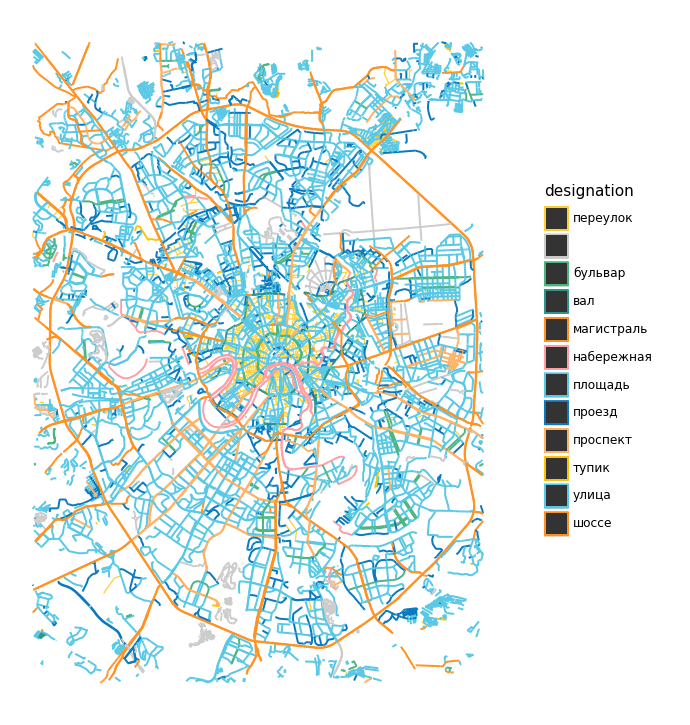

<ggplot: (167362096711)>

In [15]:
plot

In [16]:
plot.save(filename='moscow.png', format='png', width = 12, height = 18, units='in', limitsize=False, dpi=500)

D:\Anaconda3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 12 x 18 in image.
  from_inches(height, units), units), PlotnineWarning)
D:\Anaconda3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: moscow.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [129]:
import folium

streets_map = folium.Map(location=center, zoom_start=10, tiles='CartoDB positron')

for i, street in moscow.iterrows():
    weight = 2
    if 'переулок' in street['name']:
        weight = 1    
    folium.PolyLine(
        [c[::-1] for c in street.geometry.coords],
        color=colors[street['designation']],
        popup=street['name'],
        weight=weight
        ).add_to(streets_map)

folium.Rectangle([c[::-1] for c in bbox.exterior.coords]).add_to(streets_map)
streets_map.save('moscow.html')